### Spark: Youtube comments analysis
#### Write a Spark program to analyze the text data.

In this notebook, we have a dataset of user comments for youtube videos related to animals or pets. We will attempt to identify cat or dog owners based on these comments, find out the topics important to them, and then identify video creators with the most viewers that are cat or dog owners.

The dataset provided for this coding test are comments for videos related to animals and/or pets. The dataset is 240MB compressed; please download the file using this google drive link:
https://drive.google.com/file/d/1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a/view?usp=sharing

The dataset file is comma separated, with a header line defining the field names, listed here:
creator_name. Name of the YouTube channel creator.
userid. Integer identifier for the users commenting on the YouTube channels.
comment. Text of the comments made by the users.

Steps for data analysis in this project:

Step 1: Identify Cat And Dog Owners
Find the users who are cat and/or dog owners.

Step 2: Build And Evaluate Classifiers
Build classifiers for the cat and dog owners and measure the performance of the classifiers.

Step 3: Classify All The Users
Apply the cat/dog classifiers to all the users in the dataset. Estimate the fraction of all users
who are cat/dog owners.

Step 4: Extract Insights About Cat And Dog Owners
Find topics important to cat and dog owners.

Step 5: Identify Creators With Cat And Dog Owners In The Audience
Find creators with the most cat and/or dog owners. Find creators with the highest statistically
significant percentages of cat and/or dog owners.

####Import packages and libraries

In [1]:
from pyspark.sql.types import BinaryType,BooleanType,StringType,FloatType, ArrayType, DoubleType, IntegerType
from pyspark.sql.functions import when, col, lower, rand
import pyspark.sql.functions as spf
import pandas as pd

from pyspark import SparkConf, SparkContext

conf = SparkConf()
conf.set("spark.executor.memory", "4g")
conf.set("spark.driver.memory","4g")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.sql import SparkSession

sc = SparkContext(conf=conf)
spark = SparkSession(sc).builder.master("local[*]").getOrCreate()

#spark = SparkSession.builder.master("local[*]").getOrCreate()

####Read the data and drop missing value

In [3]:
#link: https://drive.google.com/file/d/1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a/view?usp=sharing
#command: wget https://drive.google.com/file/d/1o3DsS3jN_t2Mw3TsV0i7ySRmh9kyYi1a/view?usp=sharing

df = spark.read.csv("./animals_comments.csv.gz", inferSchema = True, header = True)
print("how many rows in original data: ", df.count())

# clean data: remove missing creator_name, userid or comment:
to_rmv = df['creator_name'].isNull() | df['userid'].isNull() | df['comment'].isNull()
df_all = df.filter(~to_rmv)

## drop duplicates:
df_all = df_all.dropDuplicates()
df_all = df_all.withColumn('comment', lower(col('comment')))
print("after removing missing data and duplicates, how many left: ", df_all.count())
df_all.show(10)

how many rows in original data:  5820035
after removing missing data and duplicates, how many left:  5725602
+--------------------+--------+--------------------+
|        creator_name|  userid|             comment|
+--------------------+--------+--------------------+
|       Brian Barczyk| 28322.0|since i watched t...|
|        WaysideWaifs| 89939.0|why are humans so...|
|          TobyTurner|236731.0|roses are red thi...|
|           meow meow|260511.0|..omai-wa.*reject...|
|    Brave Wilderness|420830.0|good job on getti...|
|  꼬부기아빠 My Pet Diary|459543.0|2!!0!!!만명!!!!! 축하...|
|            The Dodo|485503.0|who gave thumbs d...|
|Hope For Paws - O...|504270.0|such an intense r...|
|     Viktor Larkhill|542233.0|  oh that poor cat!!|
|    Brave Wilderness|543795.0|you can live your...|
+--------------------+--------+--------------------+
only showing top 10 rows



## Before going any further, here are the major steps for data preprocessing in this project:
### 1. label data based on pre-defined rules (currently no better way)
### 2. split each comment into a set of words and apply Word2Vec
### 3. remove non-english comments (Japanese, Korean, Chinese, all-emojis, etc. using condition len(words) > 0)
### 4. (this step is actually not necessary, already checked the feature vector is the same as step 3)then apply again Word2Vec due to step 4 (no better way, enchant.Dict("en_US") should help but need to consider if a word is misspelled if use enchant)
### 5. downsample the data for a specific label if necessary

## Drop missing comments, and label the data using certain rules

In [4]:
# Add label to data, note: data being labelled with dog_cat are confident labels i.e. user being labeled are almost surely own dog/cat
cond = (df_all["comment"].rlike("(my|My) \d* (cat|cats|kitty|kitties|dog|dogs|puppy|puppies)") | df_all["comment"].rlike("(my|My) (cat|cats|kitty|kitties|dog|dogs|puppy|puppies)") | df_all["comment"].rlike("i have (a|\d*) (cat|cats|kitty|kitties|dog|dogs|puppy|puppies)") )

df_all = df_all.withColumn('dog_cat',  cond)
print("how many users have dog/cat: ", df_all.filter(df_all['dog_cat'] == True).count())

df_all = df_all.withColumn('no_pets', ~df_all["comment"].rlike("my|My") & ~df_all["comment"].like("%have%")) 
print("how many users have no pets: ", df_all.filter(df_all['no_pets'] == True).count())

# make sure there is no conflicting row
print("how many conflicting rows: ", df_all.filter(df_all["dog_cat"] == True).filter(df_all["no_pets"] ==True).count())

def merge_label(l1, l2):
    # we already tested that l1 and l2 won't be true at the same time
    # so the only vacuum place is when l1 and l2 are both negative
    if l1:
      return 1
    elif l2:
      return 0
    return None
  
udf_merge_label = spf.udf(lambda l1,l2: merge_label(l1, l2), IntegerType())

# new label:
df_all = df_all.withColumn('label', udf_merge_label(spf.col("dog_cat"),spf.col("no_pets")))

#df_all.show(10)

## there are many ways to extract the label:
#df_all = df_all.withColumn("label", \
#                           (when(col("comment").like("%my dog%"), 1) \
#                           .when(col("comment").like("%i have a dog%"), 1) \
#                           .when(col("comment").like("%i have dog%"), 1) \
#                           .when(col("comment").like("i have a puppy%"), 1)\
#                           .when(col("comment").like("i have pupp%"), 1)\
#                           .when(col("comment").like("%my pupp%"), 1) \
#                           .when(col("comment").like("%my cat%"), 1) \
#                           .when(col("comment").like("%i have a cat%"), 1) \
#                           .when(col("comment").like("%i have cat%"), 1) \
#                           .when(col("comment").like("i have a kitt%"), 1) \
#                           .when(col("comment").like("i have kitt%"), 1) \
#                           .when(col("comment").like("%my kitt%"), 1) \
#                           .otherwise(0)))

how many users have dog/cat:  55681
how many users have no pets:  4764619
how many conflicting rows:  0


### Select 1 million rows for code development

In [5]:
df_all.orderBy(rand(seed=16807)).createOrReplaceTempView("table")
df_clean = spark.sql("SELECT * FROM table limit 1200000")

# remove 'Null' for 'label':
df_clean = df_clean.filter(df_clean['label'].isNotNull())
print("how many records in df_clean: ", df_clean.count())

df_clean.show(10)

how many records in df_clean:  1010982
+--------------------+---------+--------------------+-------+-------+-----+
|        creator_name|   userid|             comment|dog_cat|no_pets|label|
+--------------------+---------+--------------------+-------+-------+-----+
|             ViralBe| 426849.0|turkish malaklı d...|  false|   true|    0|
|    Brave Wilderness| 470403.0|         do snakes!!|  false|   true|    0|
|        Robin Seplut|1407705.0|                 6uy|  false|   true|    0|
|        Robin Seplut|1168538.0|what a gorgeous f...|  false|   true|    0|
|            Mạnh CFM|1336338.0|anh ko bình luận ...|  false|   true|    0|
|Hope For Paws - O...|2493240.0|it makes me cry ?...|  false|   true|    0|
|    Brave Wilderness| 308100.0|        i like it to|  false|   true|    0|
|       Pionpalomero1| 227252.0|que bolaaa! pion ...|  false|   true|    0|
|           best pets| 517852.0|ommmggggg is so c...|  false|   true|    0|
|    RedLeopardVideos| 724586.0|i appreciate your

## Split each comment into word list, remove stop words and non-English words, apply word2vec

In [6]:

from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline

## regular expression tokenizer to split every comment
regexTokenizer = RegexTokenizer(inputCol="comment", outputCol="word_list", pattern="\\W")
## create stop-word-remover
remover = StopWordsRemover(inputCol="word_list", outputCol="filtered")

## create a pipline:
pipeline = Pipeline(stages=[regexTokenizer, remover])
pipelineFit = pipeline.fit(df_clean)
dataset = pipelineFit.transform(df_clean)
print("Number of comments in dataset: " + str(dataset.count()))

## remove non-English words:
_size = udf(lambda l: len(l), IntegerType())
dataset = dataset.filter(_size(col("word_list")) != 0)
print("Number of English comments: " + str(dataset.count()))


Number of comments in dataset: 1010982
Number of English comments: 949130


In [7]:
## create word-to-vetor object
word2Vec = Word2Vec(vectorSize = 100, minCount = 1, inputCol="filtered", outputCol="features")
w2v_model = word2Vec.fit(dataset)
dataset = w2v_model.transform(dataset)

dataset.show(10)

+--------------------+---------+--------------------+-------+-------+-----+--------------------+--------------------+--------------------+
|        creator_name|   userid|             comment|dog_cat|no_pets|label|           word_list|            filtered|            features|
+--------------------+---------+--------------------+-------+-------+-----+--------------------+--------------------+--------------------+
|             ViralBe| 426849.0|turkish malaklı d...|  false|   true|    0|[turkish, malakl,...|[turkish, malakl,...|[-0.0304020180221...|
|    Brave Wilderness| 470403.0|         do snakes!!|  false|   true|    0|        [do, snakes]|            [snakes]|[-0.0107295308262...|
|        Robin Seplut|1407705.0|                 6uy|  false|   true|    0|               [6uy]|               [6uy]|[0.00123745854943...|
|        Robin Seplut|1168538.0|what a gorgeous f...|  false|   true|    0|[what, a, gorgeou...|[gorgeous, fluffy...|[0.20184469595551...|
|            Mạnh CFM|13363

## Remove and re-arrange some columns

In [8]:
print("How many label 1: ", dataset.filter(col('label') == 1).count())
print("How many label 0: ", dataset.filter(col('label') == 0).count())

## drop some columns:
to_be_drop = ['comment', 'word_list']
dataset = dataset.drop(*to_be_drop)

## re-arrange the columns:
df = dataset.selectExpr("creator_name", "userid", "filtered as words", "features", "dog_cat", "no_pets", "label")

df.show(10)

How many label 1:  11716
How many label 0:  937414
+--------------------+---------+--------------------+--------------------+-------+-------+-----+
|        creator_name|   userid|               words|            features|dog_cat|no_pets|label|
+--------------------+---------+--------------------+--------------------+-------+-------+-----+
|             ViralBe| 426849.0|[turkish, malakl,...|[-0.0304020180221...|  false|   true|    0|
|    Brave Wilderness| 470403.0|            [snakes]|[-0.0107295308262...|  false|   true|    0|
|        Robin Seplut|1407705.0|               [6uy]|[0.00123745854943...|  false|   true|    0|
|        Robin Seplut|1168538.0|[gorgeous, fluffy...|[0.20184469595551...|  false|   true|    0|
|            Mạnh CFM|1336338.0|[anh, ko, b, nh, ...|[-0.2733247611257...|  false|   true|    0|
|Hope For Paws - O...|2493240.0|[makes, cry, cuz,...|[-0.0102646090090...|  false|   true|    0|
|    Brave Wilderness| 308100.0|              [like]|[0.24666699767112...|  

## Downsample the data with label 0, since label 0 is around 100 times more than label 1

In [9]:
from pyspark.sql.functions import rand 

# data sampling and rebalancing
df_sample = df.select("creator_name", "userid", "words", "features", "label").sampleBy("label", fractions={1:1,0:0.015}, seed = 16807)

#lable1_set = df.filter(col('label')==1)
#lable0_set, lable0_descard = df.filter(col('label')==0).randomSplit([0.02, 0.98], seed = 0)

## concatenate the training and test sets, then shuffle the rows
#new_df = lable1_set.union(lable0_set)
#new_df = new_df.orderBy(rand(seed = 16807))

## check the size of records with label 0 and 1:
print("How many records in the new data: " + str(df_sample.count()))
print("How many label 0 in the new data: " + str(df_sample.filter(col('label')==0).count()))
print("How many label 1 in the new data: " + str(df_sample.filter(col('label')==1).count()))

df_sample.show(10)

How many records in the new data: 26012
How many label 0 in the new data: 14296
How many label 1 in the new data: 11716
+--------------------+---------+--------------------+--------------------+-----+
|        creator_name|   userid|               words|            features|label|
+--------------------+---------+--------------------+--------------------+-----+
|  Taylor Nicole Dean| 494465.0|[omfg, helping, e...|[0.09696983208414...|    0|
|    Brave Wilderness|2506412.0|            [coyote]|[-0.3064956963062...|    0|
|          Funny Pets|1312415.0|        [dogs, like]|[0.08843141421675...|    1|
|            The Dodo| 330439.0|               [wow]|[0.03257315605878...|    0|
|    Black Chinchilla| 589811.0|       [real, movie]|[-0.0655138920992...|    0|
|             Steff J| 776208.0| [steffj, rap, good]|[-0.0597639274783...|    0|
|          jiffpom 🐻| 214160.0|  [omg, soooo, cute]|[-0.0994649305939...|    0|
|  Taylor Nicole Dean|2173046.0|     [like, turtles]|[0.02005231380462.

## Try 3 models: logistic regression, random forest, gradient boosting

In [10]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import RegressionEvaluator

## train-test split:
train_set, test_set = df_sample.randomSplit([0.8, 0.2], seed = 17)
print("size of training set: ", train_set.count())
print("how many label 1 in training set: ", train_set.filter(col('label')==1).count())
print("how many label 0 in training set: ", train_set.filter(col('label')==0).count())

## define 3 models:
lr = LogisticRegression(labelCol="label", featuresCol="features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
gb = GBTClassifier(labelCol="label", featuresCol="features")
classifiers = [lr, rf, gb]
model_names = ['logistic regression', 'random forest', 'gradient boosting']

#lr_model_sum = lr_model.summary
#print("Area under the ROC for training: " + str(lr_model_sum.areaUnderROC))

## compare 3 models:
for i in range(len(classifiers)):
  model = classifiers[i].fit(train_set)
  pred = model.transform(test_set)
  pred_and_label = pred.select("prediction", "label").rdd.map(lambda l: (float(l.prediction), float(l.label)))
  metrics = BinaryClassificationMetrics(pred_and_label)
  print(model_names[i] + ": area under ROC for testing: ", metrics.areaUnderROC)
  print(model_names[i] + ": area under PR for testing: ", metrics.areaUnderPR)

size of training set:  20753
how many label 1 in training set:  9354
how many label 0 in training set:  11399
logistic regression: area under ROC for testing:  0.8801025441074988
logistic regression: area under PR for testing:  0.8342091560618262
random forest: area under ROC for testing:  0.8839261731529332
random forest: area under PR for testing:  0.8320296246646854
gradient boosting: area under ROC for testing:  0.875543607404898
gradient boosting: area under PR for testing:  0.8236668107657649


## Chose logistic regression, see how much it can be improved

In [11]:
model = lr.fit(train_set)
lr_pred = model.transform(test_set)

## compute precision and recall:
TP = lr_pred[(lr_pred['label'] == 1) & (lr_pred['prediction'] == 1.0)].count()
TN = lr_pred[(lr_pred['label'] == 0) & (lr_pred['prediction'] == 0.0)].count()
FP = lr_pred[(lr_pred['label'] == 0) & (lr_pred['prediction'] == 1.0)].count()
FN = lr_pred[(lr_pred['label'] == 1) & (lr_pred['prediction'] == 0.0)].count()

print("Logistic regression before tunning hyper-parameters:")

Accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Accuracy: ", Accuracy)

Precision = TP / (TP + FP)
print("Precision: ", Precision)

Recall = TP / (TP + FN)
print("Recall: ", Recall)

Logistic regression before tunning hyper-parameters:
Accuracy:  0.8803955124548393
Precision:  0.8593944421401908
Recall:  0.8772226926333616


## Hyper-parameter Tuning for random forest using cross-validation

In [12]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(labelCol="label", featuresCol="features")
param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.2]).addGrid(lr.aggregationDepth, [2,3,4]).build()
cross_vali = CrossValidator(estimator = lr,
                            estimatorParamMaps = param_grid,
                            evaluator = BinaryClassificationEvaluator(labelCol = 'label'),
                            numFolds = 5)

best_lr_model = cross_vali.fit(train_set)
best_lr_pred = best_lr_model.transform(test_set)

## Select (prediction, true label) and compute test error
best_lr_pred_label = best_lr_pred.select("prediction", "label").rdd.map(lambda l: (float(l.prediction), float(l.label)))
metrics = BinaryClassificationMetrics(best_lr_pred_label)
print("Best logistic regression: area under ROC for testing: ", metrics.areaUnderROC)
print("Best logistic regression: area under PR for testing: ", metrics.areaUnderPR)

# Evaluate the testing result from different perspective
print("\nEvaluate the testing result from different perspective:")
AUROC, AUPR = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(best_lr_pred),\
                            BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR").evaluate(best_lr_pred)
print("Best logistic regression: area under ROC: ", AUROC)
print("Best logistic regression: area under PR: ", AUPR)

Best logistic regression: area under ROC for testing:  0.8794512674356988
Best logistic regression: area under PR for testing:  0.8326815654918033

Evaluate the testing result from different perspective:
Best logistic regression: area under ROC:  0.9389277412441985
Best logistic regression: area under PR:  0.8843070247113121


## Evaluate the best logistic regression model using precision & recall

In [13]:
TP = best_lr_pred[(best_lr_pred['label'] == 1) & (best_lr_pred['prediction'] == 1.0)].count()
TN = best_lr_pred[(best_lr_pred['label'] == 0) & (best_lr_pred['prediction'] == 0.0)].count()
FP = best_lr_pred[(best_lr_pred['label'] == 0) & (best_lr_pred['prediction'] == 1.0)].count()
FN = best_lr_pred[(best_lr_pred['label'] == 1) & (best_lr_pred['prediction'] == 0.0)].count()

Accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Best Accuracy: ", Accuracy)

Precision = TP / (TP + FP)
print("Best Precision: ", Precision)

Recall = TP / (TP + FN)
print("Best Recall: ", Recall)

Best Accuracy:  0.8796349115801483
Best Precision:  0.8576748034753827
Best Recall:  0.8776460626587638


## Random Forrest

In [14]:

rf = RandomForestClassifier(labelCol='label', featuresCol="features", seed = 17)

param_grid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 15, 20]).addGrid(rf.numTrees, [10, 15, 20]).build()
cross_vali = CrossValidator(estimator = rf,
                            estimatorParamMaps = param_grid,
                            evaluator = BinaryClassificationEvaluator(labelCol = 'label'),
                            numFolds = 5)

best_rf = cross_vali.fit(train_set)
best_rf_pred = best_rf.transform(test_set)

# Evaluate the testing result from different perspective
AUROC, AUPR = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(best_rf_pred),\
                            BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR").evaluate(best_rf_pred)
print("Best random forest: area under ROC: ", AUROC)
print("Best random forest: area under PR: ", AUPR)

Best random forest: area under ROC:  0.962437199625763
Best random forest: area under PR:  0.9441724192643061


## Evaluate the best random forest model using precision & recall

In [15]:
TP = best_rf_pred[(best_rf_pred['label'] == 1) & (best_rf_pred['prediction'] == 1.0)].count()
TN = best_rf_pred[(best_rf_pred['label'] == 0) & (best_rf_pred['prediction'] == 0.0)].count()
FP = best_rf_pred[(best_rf_pred['label'] == 0) & (best_rf_pred['prediction'] == 1.0)].count()
FN = best_rf_pred[(best_rf_pred['label'] == 1) & (best_rf_pred['prediction'] == 0.0)].count()

Accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Random forest best accuracy: ", Accuracy)

Precision = TP / (TP + FP)
print("Random forest best precision: ", Precision)

Recall = TP / (TP + FN)
print("Random forest best recall: ", Recall)

Random forest best accuracy:  0.9075869937250428
Random forest best precision:  0.8947811447811448
Random forest best recall:  0.9000846740050804


## GDBT hyper-parameter tunning: to be continued

In [16]:
#gb = GBTClassifier(labelCol="label", featuresCol="features", seed = 17)

#param_grid = ParamGridBuilder().addGrid(gb.maxDepth, [5, 10, 15, 20]).addGrid(gb.maxIter, [10, 15, 20]).build()
#cross_vali = CrossValidator(estimator = gb,
#                            estimatorParamMaps = param_grid,
#                            evaluator = BinaryClassificationEvaluator(labelCol = 'label'),
#                            numFolds = 5)

#best_gb = cross_vali.fit(train_set)
#best_gb_pred = best_gb.transform(test_set)

# Evaluate the testing result from different perspective
#AUROC, AUPR = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(best_gb_pred),\
#                            BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR").evaluate(best_gb_pred)
#print("Best gradient boosting: area under ROC: ", AUROC)
#print("Best gradient boosting: area under PR: ", AUPR)

## Pick up the best model (Random Forest) and apply it to all users
## In order to classify all users, the following preprocessing needs to be done:
## 0. Remove NULL from label
## 1. Split each comment into word list, remove stop words and non-English words, apply word2vec
## 2. Remove and re-arrange some columns

In [17]:
best_model = best_rf

# remove 'Null' for 'label':
print("how many records in df_all:", df_all.count())
df_all_new = df_all.filter(df_all['label'].isNotNull())
print("how many records after removal of NULL: ", df_all_new.count())

## create a pipline:
#pipeline = Pipeline(stages=[regexTokenizer, remover])
pipelineFit = pipeline.fit(df_all_new)
dataset_all = pipelineFit.transform(df_all_new)

## remove non-English words:
#_size = udf(lambda l: len(l), IntegerType())
dataset_all = dataset_all.filter(_size(col("word_list")) != 0)
print("Number of English comments: ", dataset_all.count())

## create word-to-vetor object
dataset_all = w2v_model.transform(dataset_all)

## drop and re-arrange some columns:
to_drop = ['comment', 'word_list']
dataset_all = dataset_all.drop(*to_drop)
df_all = dataset_all.selectExpr("creator_name", "userid", "filtered as words", "features", "label")
df_all.show(100)

how many records in df_all: 5725602
how many records after removal of NULL:  4820300
Number of English comments:  4527037
+--------------------+---------+--------------------+--------------------+-----+
|        creator_name|   userid|               words|            features|label|
+--------------------+---------+--------------------+--------------------+-----+
|        WaysideWaifs|  89939.0|   [humans, inhuman]|[-0.1020280960947...|    0|
|           meow meow| 260511.0|[omai, wa, reject...|[-0.0453906494658...|    0|
|    Brave Wilderness| 420830.0|[good, job, getti...|[0.10203937347978...|    0|
|  꼬부기아빠 My Pet Diary| 459543.0|              [2, 0]|[0.27150300145149...|    0|
|            The Dodo| 485503.0|[gave, thumbs, vi...|[0.05786870845726...|    0|
|Hope For Paws - O...| 504270.0|[intense, rescue,...|[-0.0895010225940...|    0|
|     Viktor Larkhill| 542233.0|     [oh, poor, cat]|[0.19487657149632...|    0|
|    Brave Wilderness| 543795.0|[live, live, free...|[-0.11225935311

## Evaluate the 'best' model on all users:

In [18]:
best_model_pred = best_model.transform(df_all)

# Evaluate the testing result:
AUROC, AUPR = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC").evaluate(best_model_pred),\
                            BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderPR").evaluate(best_model_pred)
print("Random forest for all: area under ROC: ", AUROC)
print("Random forest for all: area under PR: ", AUPR)

## compute accuracy, precision and recall:
TP = best_model_pred[(best_model_pred['label'] == 1) & (best_model_pred['prediction'] == 1.0)].count()
TN = best_model_pred[(best_model_pred['label'] == 0) & (best_model_pred['prediction'] == 0.0)].count()
FP = best_model_pred[(best_model_pred['label'] == 0) & (best_model_pred['prediction'] == 1.0)].count()
FN = best_model_pred[(best_model_pred['label'] == 1) & (best_model_pred['prediction'] == 0.0)].count()

Accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Random forest for all: accuracy: ", Accuracy)

Precision = TP / (TP + FP)
print("Random forest for all: precision: ", Precision)

Recall = TP / (TP + FN)
print("Random forest for all: recall: ", Recall)

Random forest for all: area under ROC:  0.967769332813418
Random forest for all: area under PR:  0.33285212116579116
Random forest for all: accuracy:  0.9161106922695794
Random forest for all: precision:  0.11927512975158651
Random forest for all: recall:  0.9117293152062642


In [19]:
df_all.count()

4527037

## Get insigts of users: find out the topics important to them
## 1. Use TF-IDF to compute word importance
## 2. Filter data with only cat-dog-owner records, then conduct LDA.
## 3. See most frequent words appears in the cat and dog owners.
## 4. See wordcloud for the words.

## Data preparation for topic analysis

In [20]:
## pickup real owners
real_owner = df_all.filter(df_all['label']==1)
print("how many real pet owners: ", real_owner.count())

## pickup predicted owners:
pred_owner = best_model_pred.filter(best_model_pred['prediction']==1.0)
print("how many predicted pet owners: ", pred_owner.count())

def real_and_pred(lr, lp):
    if lr >0 or lp > 0:
      return 1
    else:
      return 0
udf_real_and_pred = spf.udf(lambda lr,lp: real_and_pred(lr, lp), IntegerType())
# new label:
df_owners = best_model_pred.withColumn('temp_label', udf_real_and_pred(spf.col("label"),spf.col("prediction")))
df_owners = df_owners.filter(df_owners['temp_label']==1).select("creator_name", "userid", "words").withColumn("doc_id", spf.monotonically_increasing_id())
print("how many concatenated owners (real+predicted): ", df_owners.count())

how many real pet owners:  55681
how many predicted pet owners:  425621
how many concatenated owners (real+predicted):  430536


In [21]:
df_owners.show(20)

+--------------------+---------+--------------------+------+
|        creator_name|   userid|               words|doc_id|
+--------------------+---------+--------------------+------+
|             ViralBe| 799211.0|[fuck, list, like...|     0|
|    Cole & Marmalade| 846766.0|[like, sing, fron...|     1|
|        Paws Channel|1400214.0|[hi, video, seems...|     2|
|     MARLENE MCCOHEN|2225630.0|[hey, dogs, racis...|     3|
|     prairiefirewind| 558119.0|[looks, like, got...|     4|
|    Brave Wilderness|1143997.0|[name, zeus, roma...|     5|
|     Gohan The Husky|1876972.0|[beautiful, dog, ...|     6|
|Hope For Paws - O...|2109487.0|[want, bad, gave,...|     7|
|          MaxluvsMya|2339374.0|[im, sorry, stupi...|     8|
|       Brian Barczyk| 177646.0|[hope, dog, gits,...|     9|
|            Gardea23|1437508.0|[mishka, think, y...|    10|
|    Brave Wilderness|1684148.0|[missed, opportun...|    11|
|             Steff J|1958148.0|[mosquito, larva,...|    12|
|      Myaquariuminfo| 3

In [22]:
## user TF-IDF to compute word importance
from pyspark.ml.feature import CountVectorizer, IDF, Tokenizer
from pyspark.ml.clustering import LDA

# TF model
count_vec = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=123241, minDF=2.0)
count_vec_model = count_vec.fit(df_owners)  
featurizedData = count_vec_model.transform(df_owners)
vocab = count_vec_model.vocabulary

# IDF model
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2)
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)
# rescaledData.show()
rescaledData.cache()

# LDA model to group data
lda = LDA(k=2, seed=666, optimizer="em")
lda_model = lda.fit(rescaledData.select("features"))

# Get important topics for each group
topics = lda_model.describeTopics(100)

# convert to pandas to display
pddf = topics.select("termIndices").toPandas()

topics.show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[4, 0, 2, 1, 3, 5...|[0.00799203923707...|
|    1|[0, 1, 2, 3, 5, 6...|[0.00674303927287...|
+-----+--------------------+--------------------+



In [23]:
# print out the topics most import to the two groups of people
group1, group2= [], []
for num in pddf.loc[0][0]:
    group1.append(vocab[num])    
for num in pddf.loc[1][0]:
    group2.append(vocab[num])
print("Group 1 most important toptics are: {}".format(str(group1)))
print("Group 2 most important toptics are: {}".format(str(group2)))

Group 1 most important toptics are: ['cats', 'dog', 'cat', 'like', 'dogs', 'love', 'one', 'im', 'get', 'dont', 'know', 'cute', 'video', 'people', 'much', 'see', 'good', 'got', 'really', 'think', 'lol', 'want', 'time', 'little', 'another', 'food', 'looks', 'animals', 'hes', 'puppy', 'even', 'u', 'make', 'kitten', 'hope', 'go', 'happy', 'thats', '3', 'thank', 'need', 'also', 'give', 'old', 'videos', 'take', 'way', 'still', 'never', 'help', 'kitty', 'going', 'shes', 'well', 'away', 'back', 'always', 'thing', 'poor', '2', 'ever', 'bad', 'great', 'best', 'sad', 'beautiful', 'home', 'cant', 'kittens', 'put', 'big', 'please', 'look', 'day', 'around', 'right', 'didnt', 'mom', 'better', 'care', 'two', 'years', 'ive', 'wish', 'sweet', 'first', 'feel', 'keep', 'life', 'owner', 'pet', 'baby', 'house', 'say', 'doesnt', 'animal', 'watching', 'new', 'something', 'black']
Group 2 most important toptics are: ['dog', 'like', 'cat', 'dogs', 'love', 'one', 'get', 'im', 'dont', 'people', 'know', 'think', '

In [24]:
featurizedData.show(10)

+--------------------+---------+--------------------+------+--------------------+
|        creator_name|   userid|               words|doc_id|         rawFeatures|
+--------------------+---------+--------------------+------+--------------------+
|             ViralBe| 799211.0|[fuck, list, like...|     0|(45554,[0,1,34,24...|
|    Cole & Marmalade| 846766.0|[like, sing, fron...|     1|(45554,[1,2,15,11...|
|        Paws Channel|1400214.0|[hi, video, seems...|     2|(45554,[3,6,11,13...|
|     MARLENE MCCOHEN|2225630.0|[hey, dogs, racis...|     3|(45554,[3,6,128,2...|
|     prairiefirewind| 558119.0|[looks, like, got...|     4|(45554,[1,16,18,2...|
|    Brave Wilderness|1143997.0|[name, zeus, roma...|     5|(45554,[108,121,2...|
|     Gohan The Husky|1876972.0|[beautiful, dog, ...|     6|(45554,[0,23,79,1...|
|Hope For Paws - O...|2109487.0|[want, bad, gave,...|     7|(45554,[3,20,55,6...|
|          MaxluvsMya|2339374.0|[im, sorry, stupi...|     8|(45554,[8,9,13,19...|
|       Brian Ba

In [25]:
rescaledData.show(10)

+--------------------+---------+--------------------+------+--------------------+--------------------+
|        creator_name|   userid|               words|doc_id|         rawFeatures|            features|
+--------------------+---------+--------------------+------+--------------------+--------------------+
|             ViralBe| 799211.0|[fuck, list, like...|     0|(45554,[0,1,34,24...|(45554,[0,1,34,24...|
|    Cole & Marmalade| 846766.0|[like, sing, fron...|     1|(45554,[1,2,15,11...|(45554,[1,2,15,11...|
|        Paws Channel|1400214.0|[hi, video, seems...|     2|(45554,[3,6,11,13...|(45554,[3,6,11,13...|
|     MARLENE MCCOHEN|2225630.0|[hey, dogs, racis...|     3|(45554,[3,6,128,2...|(45554,[3,6,128,2...|
|     prairiefirewind| 558119.0|[looks, like, got...|     4|(45554,[1,16,18,2...|(45554,[1,16,18,2...|
|    Brave Wilderness|1143997.0|[name, zeus, roma...|     5|(45554,[108,121,2...|(45554,[108,121,2...|
|     Gohan The Husky|1876972.0|[beautiful, dog, ...|     6|(45554,[0,23,

#### Generate word cloud for frequently-appeared words in the comments with users having pets

In [26]:
## count the word frequency
tmp = best_model_pred.filter("prediction = 1.0").select("creator_name","userid","words")
wc = tmp.rdd.flatMap(lambda l: l.words).countByValue().items()

## sort the (word, count) pair by count
#wcSorted = sorted(wc, key = lambda pair: pair[1],reverse = True)
#wcSorted

In [29]:
## Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install wordcloud

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x1036ac588>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /simple/wordcloud/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x1036ac5f8>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /simple/wordcloud/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x1036ace80>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)': /simple/wordcloud/
  Retrying (Retry(tota

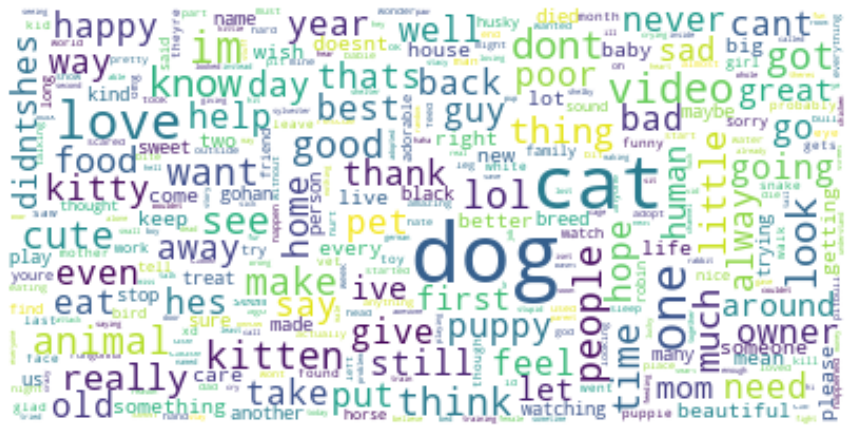

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = "".join([(k + " ")*v for k,v in wc])

wcloud = WordCloud(background_color = "white", max_words = 10000, collocations = False,
               contour_width = 3, contour_color='steelblue', max_font_size = 40)

# Generate a word cloud image
wcloud.generate(text)

# Display the generated image:
# the matplotlib way:
fig,ax0=plt.subplots(nrows=1,figsize=(12,8))
ax0.imshow(wcloud,interpolation='bilinear')

ax0.axis("off")
#display(fig)
plt.tight_layout()

## Identify Creators With Cat And Dog Owners In The Audience

In [33]:
from pyspark.sql.functions import countDistinct
print("Top 20 YouTubers with most number of pet owners")
tmp = best_model_pred.filter("prediction = 1.0")
creators = tmp.groupBy('creator_name').agg(countDistinct('userid')).sort('count(DISTINCT userid)',ascending= False)
creators.show(20)

Top 20 YouTubers with most number of pet owners
+--------------------+----------------------+
|        creator_name|count(DISTINCT userid)|
+--------------------+----------------------+
|            The Dodo|                 33844|
|    Brave Wilderness|                 17325|
|Hope For Paws - O...|                 16938|
|        Robin Seplut|                 16880|
|  Taylor Nicole Dean|                 15601|
|     Gohan The Husky|                 15034|
|           Vet Ranch|                 11651|
|    Cole & Marmalade|                 10697|
|   Talking Kitty Cat|                 10022|
|       Brian Barczyk|                  9290|
|Gone to the Snow ...|                  8385|
|          stacyvlogs|                  7199|
|        Paws Channel|                  6761|
|     Viktor Larkhill|                  6282|
|            ViralHog|                  5721|
|Zak Georges Dog T...|                  5500|
|           meow meow|                  4647|
|             ViralBe|          

## Analysis and Future work

## From project to CV format 
## 1. overview of project 
## 2. data clean and modeling 
## 3. data analysis 
## 4. build ml model
## 5. recommendation based on the model results